In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

import pde_functions as PDE

## Nomenclature and PDE Types
## $u= u(t,x)$,  $u_{x} = \frac{\partial{u}}{\partial{x}}$,  $u_{xx}=\frac{\partial^2{u}}{\partial{x}^2}$, $u_{t} = \frac{\partial{u}}{\partial{t}}$,  $u_{tt}=\frac{\partial^2{u}}{\partial{t}^2}$

### General Form:
## $Au_{xx} + Bu_{xt} + Cu_{tt} + Du_{x} + Eu_{t} + Fu = G$

> ### $B^2 - 4AC < 0$: Elliptical PDE
> ### $B^2 - 4AC > 0$: Hyperbolic PDE
> ### $B^2 - 4AC = 0$: Parabolic PDE


##### The choice of method depends on the specific characteristics of the PDE, including linearity, the presence of diffusion terms, and the nature of wave propagation. Each method has its strengths and is suited to particular types of problems, ensuring accurate and efficient solutions.
**below is a summary of PDE solution types, consolidated by ChatGPT (v 4o, @05/21/2024):*

### I. Elliptic PDEs

Elliptic PDEs are often used to describe steady-state phenomena, such as potential flow, electrostatics, and steady-state heat conduction. 

#### Linear Elliptic PDEs (e.g., Poisson's equation, Laplace's equation)

1. **Finite Difference Method (FDM)**:
   - Suitable for structured grids.
   - Example: Solving Laplace’s equation using a five-point stencil.

2. **Finite Element Method (FEM)**:
   - Suitable for complex geometries and unstructured grids.
   - Example: Solving Poisson’s equation in a domain with irregular boundaries.

3. **Multigrid Methods**:
   - Highly efficient for large-scale problems.
   - Can be combined with FDM or FEM.

#### Nonlinear Elliptic PDEs (e.g., nonlinear Poisson equation)

1. **Newton-Raphson Method combined with FDM or FEM**:
   - Iterative linearization method.
   - Example: Solving nonlinear Poisson’s equation using Newton-Raphson with FEM.

2. **Multigrid Methods for Nonlinear Problems**:
   - Adapts multigrid techniques for nonlinear equations.

### II. Parabolic PDEs

Parabolic PDEs describe diffusion processes, such as heat conduction and diffusion of substances.

#### Linear Parabolic PDEs (e.g., heat equation with constant coefficients)

1. **Implicit Methods (e.g., Crank-Nicolson, Backward Euler)**:
   - Unconditionally stable.
   - Suitable for stiff problems and long-time integration.

2. **Explicit Methods (e.g., Forward Euler)**:
   - Simple to implement but conditionally stable (CFL condition).
   - Suitable for problems with mild stiffness.

3. **Finite Element Method (FEM)**:
   - Handles complex geometries.
   - Can be combined with time-stepping schemes like backward Euler or Crank-Nicolson.

#### Nonlinear Parabolic PDEs (e.g., heat equation with temperature-dependent diffusivity)

1. **Implicit Methods with Newton-Raphson Iteration**:
   - Handles nonlinear terms effectively.
   - Example: Solving a nonlinear heat equation with Crank-Nicolson and Newton-Raphson.

2. **Explicit Methods with Small Time Steps**:
   - Suitable for problems where stability constraints are manageable.

### III. Hyperbolic PDEs

Hyperbolic PDEs describe wave propagation, such as sound waves, electromagnetic waves, and fluid dynamics.

#### Linear Hyperbolic PDEs (e.g., wave equation)

1. **Explicit Finite Difference Methods (e.g., Lax-Wendroff, Leapfrog)**:
   - Suitable for capturing wave propagation.
   - Example: Solving the wave equation using the Lax-Wendroff method.

2. **Method of Characteristics**:
   - Directly follows the paths of wave propagation.

3. **Finite Volume Method (FVM)**:
   - Suitable for conservation laws.
   - Example: Solving linear advection equations using FVM.

#### Nonlinear Hyperbolic PDEs (e.g., inviscid Burgers' equation, Euler equations)

1. **Godunov's Method**:
   - Handles shock waves and discontinuities effectively.
   - Example: Solving the inviscid Burgers' equation using Godunov’s method.

2. **High-Resolution Schemes (e.g., Total Variation Diminishing (TVD) methods, Essentially Non-Oscillatory (ENO) schemes, Weighted ENO (WENO) schemes)**:
   - Suitable for capturing complex wave interactions without spurious oscillations.

3. **Finite Volume Method (FVM) with Riemann Solvers**:
   - Handles conservation laws and discontinuities well.
   - Example: Solving the Euler equations using FVM with an approximate Riemann solver.

### Summary Table

| **PDE Type** | **Linear** | **Nonlinear** |
|--------------|------------|---------------|
| **Elliptic** | FDM, FEM, Multigrid | Newton-Raphson with FDM/FEM, Nonlinear Multigrid |
| **Parabolic** | Implicit Methods (Crank-Nicolson, Backward Euler), Explicit Methods, FEM | Implicit Methods with Newton-Raphson, Explicit Methods with Small Time Steps |
| **Hyperbolic** | Explicit FDM (Lax-Wendroff, Leapfrog), Method of Characteristics, FVM | Godunov's Method, High-Resolution Schemes (TVD, ENO, WENO), FVM with Riemann Solvers |

-----

## Sidebar: Node vs Grid number 

All PDE solution methods should be able to take in either a desired dx & dt (node increment spacing), or the desired number of time and space nodes to anayze.  Length, maximum time, and any necessary diffusion/transport coefficients also need to be specified ny the user.

Comparing the two methods, in general:

#### Option 1: Enter desired number of nodes

In [2]:
# Length of Rod:
L = 3

# Length of time to analyze:
t_max = 1

# Desired number of nodes (really partitions)
x_grid_nodes = 30

# Desired number of time steps to analyze
t_grid_nodes = 500

In [3]:
# Calcs
dx = L/x_grid_nodes
dt = t_max/t_grid_nodes

x_grid = np.linspace(0,L,x_grid_nodes+1) # two boundary nodes at 0 & L, rest are inner nodes
t_grid = np.linspace(0,t_max,t_grid_nodes+1) # Need to change node here by +1 for proper t-intervals

In [4]:
dt, dx, len(x_grid), x_grid, len(t_grid), t_grid

(0.002,
 0.1,
 31,
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 501,
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
        0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
        0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
        0.108, 0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 , 0.122, 0.124,
        0.126, 0.128, 0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142,
        0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 ,
        0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178,
        0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196,
        0.198

#### Option 2: Enter desired time and space intervals (dx and dt)

In [5]:
# Length of Rod:
L = 3

# Length of time to analyze:
t_max = 1

# Desired size of spatial step
dx = .1

# Desired size of time step
dt = .002

In [6]:
# Calcs
x_grid_nodes = int(L/dx)
t_grid_nodes = int(t_max/dt)

x_grid = np.linspace(0,L,x_grid_nodes+1) # two boundary nodes at 0 & L, rest are inner nodes
t_grid = np.linspace(0,t_max,t_grid_nodes+1) # Need to change node here by +1 for proper t-intervals

In [7]:
x_grid_nodes, t_grid_nodes, len(x_grid), x_grid, len(t_grid), t_grid

(30,
 500,
 31,
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 501,
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
        0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
        0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
        0.108, 0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 , 0.122, 0.124,
        0.126, 0.128, 0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142,
        0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 ,
        0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178,
        0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196,
        0.198, 0

----

#### Using a common set of initial conditions for first few examples:

In [8]:
# Initial Condition Functions
def f_u_0_x(x):
    '''
    Assigns the initial values (t=0) for u, inner nodes.
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return np.sin(np.pi*x)

def f_u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''    
    return 0

def f_u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

## 1. Laplace: $u_{xx} = 0$
Elliptic PDE
*Note: Laplace is similar to the wave equation with constant t and no $c^2$ term.*

## 2. Poisson: $u_{xx} = u$
Note: Often given as $-u_{xx} = f$

## 3. Transport (w/o decay/growth): $u_{t} + cu_{x} = 0, \tiny\text{where c = a constant}$

Explicit:

In [9]:
# Create explicit function
def transport_1D_explicit_timestep(u_line,c,m,dt,dx):
    '''
    Takes in:
    u_line - an 1D array
    m - a space index
    dt - time step
    dx - x step
    '''
    return  c * (dt/(2*dx)) * (u_line[m-1] - u_line[m+1]) + u_line[m]

In [10]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_3 = 3
t_max_3 = 10

dx_3 = .01
dt_3 = .0001

c_3 = .1

# -- Calculated
Nx_3 = int(L_3/dx_3) + 1
Nt_3 = int(t_max_3/dt_3) +1

x_grid_3 = np.linspace(0,L_3,Nx_3)
t_grid_3 = np.linspace(0,t_max_3,Nt_3)

# -- Create solution data holder
U_3 = []

# -- Append initial conditions (t = 0)
u_t_x_0 = []

for x in x_grid_3:
    u_t_x_0.append(f_u_0_x(x/L_3))

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_3.append(u_t_x_0)

for j in range(len(t_grid_3)):
    u_t_x = []
    
    u_previous = U_3[-1]
    
    for m in range(1,len(x_grid_3)-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        #! - Note: can use classes or other methods to choose which function is used
        u = transport_1D_explicit_timestep(u_previous,c_3,m,dt_3,dx_3)
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(j*dt_3))
    u_t_x.append(f_u_t_L(j*dt_3))

    # Now append the full solutions matrix
    U_3.append(u_t_x) 

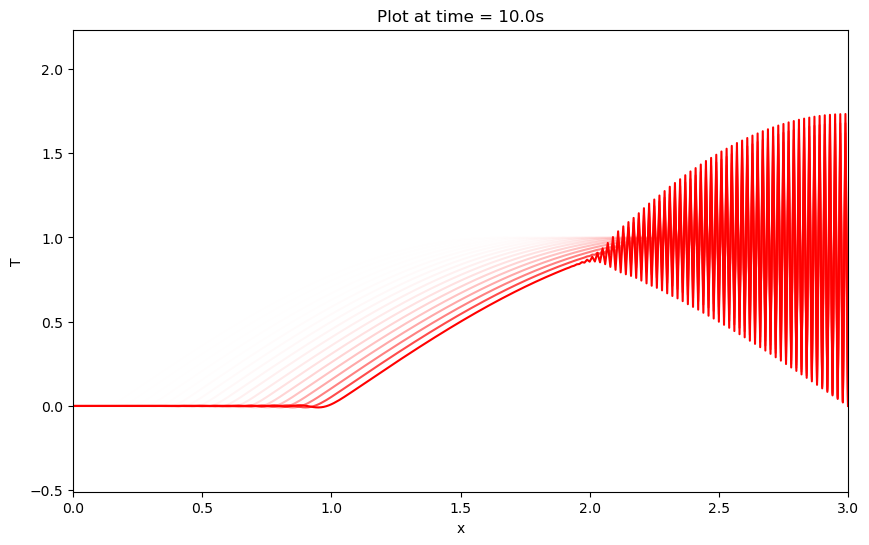

In [11]:
steps = 20
t_min_plot = 0
t_max_plot = t_max_3
x_min_plot = 0
x_max_plot = L_3
PDE.PDE_plotter_1D(U_3, L_3, t_max_3, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, style='heat')

CR Method:

## 3a. Transport w/ decay/growth: $u_{t} + cu_{x} = u, \tiny\text{where c = a constant}$

Explicit

In [12]:
# Create explicit function
def transport_decay_1D_explicit_timestep(u_line,c,m,dt,dx):
    '''
    Takes in:
    u_line - an 1D array
    m - a space index
    dt - time step
    dx - x step
    '''
    return  c * (dt/(2*dx)) * (u_line[m-1] - u_line[m+1]) + u_line[m] + (dt * u_line[m])

In [13]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_3a = 3
t_max_3a = 10

dx_3a = .01
dt_3a = .0001

c_3a = .1

# -- Calculated
Nx_3a = int(L_3a/dx_3a) + 1
Nt_3a = int(t_max_3a/dt_3a) +1

x_grid_3a = np.linspace(0,L_3a,Nx_3a)
t_grid_3a = np.linspace(0,t_max_3a,Nt_3a)

# -- Create solution data holder
U_3a = []

# -- Append initial conditions (t = 0)
u_t_x_0 = []

for x in x_grid_3a:
    u_t_x_0.append(f_u_0_x(x/L_3a))

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_3a.append(u_t_x_0)

for j in range(len(t_grid_3a)):
    u_t_x = []
    
    u_previous = U_3a[-1]
    
    for m in range(1,len(x_grid_3a)-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        #! - Note: can use classes or other methods to choose which function is used
        u = transport_decay_1D_explicit_timestep(u_previous,c_3a,m,dt_3a,dx_3a)
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(j*dt_3a))
    u_t_x.append(f_u_t_L(j*dt_3a))

    # Now append the full solutions matrix
    U_3a.append(u_t_x) 

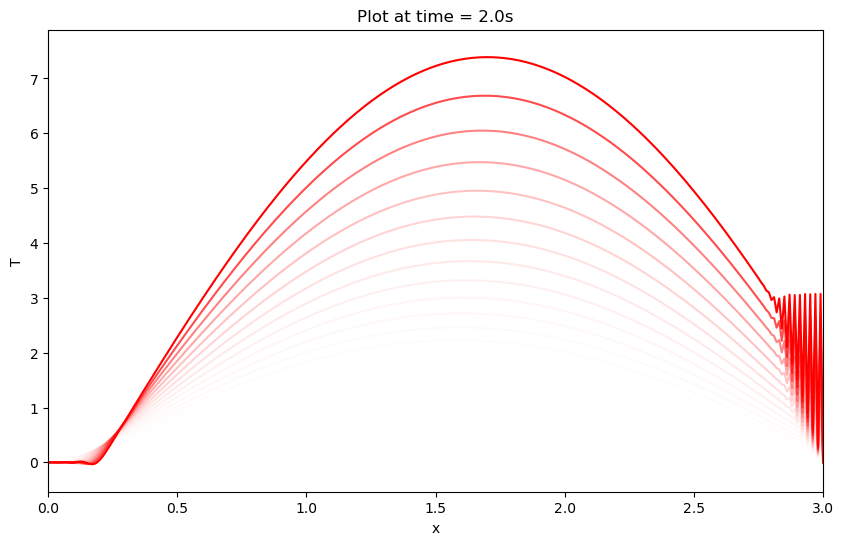

In [14]:
steps = 20
t_min_plot = 0
t_max_plot = t_max_3a/5
x_min_plot = 0
x_max_plot = L_3a
PDE.PDE_plotter_1D(U_3a, L_3a, t_max_3a, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, style='heat')

CR Method

## 4.  Nonlinear Transport (Inviscid Burgers): $u_{t} + (u)u_{x} = 0$

In [15]:
# Create explicit function
def invisic_burgers_1D_explicit_timestep(u_line,m,dt,dx):
    '''
    Takes in
    u_line - an 1D array
    m - a space index
    dt - time step
    dx - x step
    '''
    return  u_line[m] * ((dt/(2*dx)) * (u_line[m-1] - u_line[m+1]) + 1)

In [16]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_4 = 3
t_max_4 = 1

dx_4 = .1
dt_4 = .00001

# -- Calculated
Nx_4 = int(L_4/dx_4) + 1
Nt_4 = int(t_max_4/dt_4)

x_grid_4 = np.linspace(0,L_4,Nx_4)
t_grid_4 = np.linspace(0,t_max_4,Nt_4)

# -- Create solution data holder
U_4 = []

# -- Append initial conditions (t = 0)
u_t_x_0 = []

for x in x_grid_4:
    u_t_x_0.append(f_u_0_x(x/L))

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_4.append(u_t_x_0)

for j in range(len(t_grid_4)):
    u_t_x = []
    
    u_previous = U_4[-1]
    
    for m in range(1,len(x_grid_4)-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        #! - Note: can use classes or other methods to choose which function is used
        u = invisic_burgers_1D_explicit_timestep(u_previous,m,dt_4,dx_4)
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(j*dt_4))
    u_t_x.append(f_u_t_L(j*dt_4))

    # Now append the full solutions matrix
    U_4.append(u_t_x) 

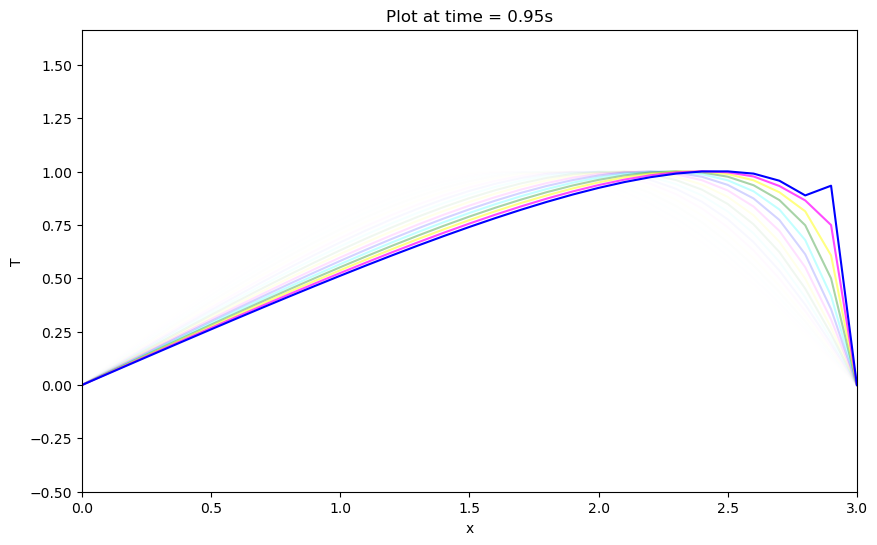

In [17]:
steps_4 = 20
t_min_plot_4 = 0
t_max_plot_4 = t_max_4
x_min_plot_4 = 0
x_max_plot_4 = L_4
PDE.PDE_plotter_1D(U_4, L_4, t_max_4, steps_4, t_min_plot_4, t_max_plot_4, x_min_plot_4, x_max_plot_4)

## 5.  Diffusion Equation (Heat): $u_{t} = \alpha{}u_{xx}, \tiny\text{where } \alpha \tiny\text{ = a constant}$
***Note: Use 'a' for $\alpha$***

In [18]:
def heat_1D_explicit_timestep(u_line,a,m,dt,dx):
    '''
    Takes in
    u_line - an 1D array
    a - diffusion constant
    m - a space index
    dt - time step
    dx - x step
    '''
    mu = a * (dt/dx**2) # Related to dt above, must be </= to .5
    return  u_line[m] + mu*(u_line[m+1] + u_line[m-1] - 2*u_line[m])

In [19]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_5 = 3
t_max_5 = 1

dx_5 = .01
dt_5 = .0001

a_5 = .5

# Create a stability check
if dt_5 > (dx_5**2 / (2*a_5)):
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.\nNote: dt must </= {dx_5**2 / (2*a_5)}")

# -- Calculated
Nx_5 = int(L_5/dx_5) + 1
Nt_5 = int(t_max_5/dt_5)

x_grid_5 = np.linspace(0,L_5,Nx_5)
t_grid_5 = np.linspace(0,t_max_5,Nt_5)

# -- Create solution data holder
U_5 = []

# -- Append initial conditions (t = 0)
u_t_x_0 = []

for x in x_grid_5:
    u_t_x_0.append(f_u_0_x(x))

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_5.append(u_t_x_0)

for j in range(len(t_grid_5)):
    u_t_x = []
    
    u_previous = U_5[-1]
    
    for m in range(1,len(x_grid_5)-1):
        u = heat_1D_explicit_timestep(u_previous,a_5,m,dt_5,dx_5)
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(j*dt_5))
    u_t_x.append(f_u_t_L(j*dt_5))

    # Now append the full solutions matrix
    U_5.append(u_t_x) 

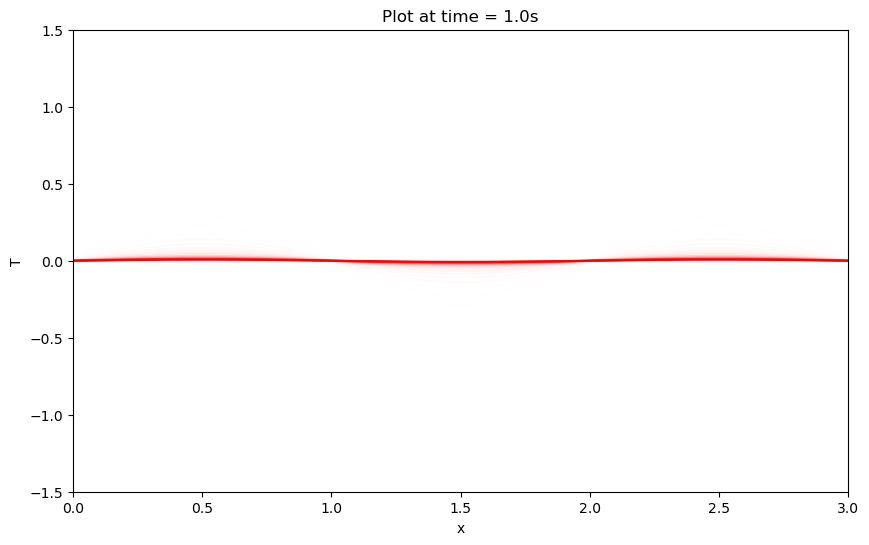

In [20]:
steps_5 = 20
t_min_plot_5 = 0
t_max_plot_5 = 1
x_min_plot_5 = 0
x_max_plot_5 = 3
PDE.PDE_plotter_1D(U_5, L_5, t_max_5, steps_5, t_min_plot_5, t_max_plot_5, x_min_plot_5, x_max_plot_5, style="heat")

## 6. Wave Equation (Linear): $u_{tt} = c^{2}u_{xx}, \tiny\text{where c = a constant}$

In [ ]:
u_tt = c**2 * (u_xx + u_yy)
# Have to approximate partials for 2D

In [21]:
def wave_1D_explicit_timestep(u_line,u_line_previous,c,m,dt,dx):
    '''
    Takes in
    u_line - an 1D array
    u_line_previous - an 1D array
    m - a space index
    dt - time step
    dx - x step
    
    ***Add notes here about derivation from the centered difference from each side of the equation***
    '''
    return (dt**2/dx**2) * c**2 * (u_line[m+1] + u_line[m-1] - 2*u_line[m]) + 2*u_line[m] - u_line_previous[m]

In [22]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_6 = 3
t_max_6 = 5

dx_6 = .01
dt_6 = .0001

c_6 = .5

# Create a stability check
if dt_6**2 > (dx_6**2 / (2*c_6**2)):
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.\nNote: dt must </= {dx_5**2 / (2*c_5)}")

# -- Calculated
Nx_6 = int(L_6/dx_6) + 1
Nt_6 = int(t_max_6/dt_6) + 1

x_grid_6 = np.linspace(0,L_6,Nx_6)
t_grid_6 = np.linspace(0,t_max_6,Nt_6)

# -- Create solution data holder
U_6 = []

# -- Append initial conditions (t = 0)
u_t_x_0 = []

for x in x_grid_6:
    u_t_x_0.append(f_u_0_x(x/L))

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_6.append(u_t_x_0)

u_previous_2 = U_6[-1]

for j in range(len(t_grid_6)):
    u_t_x = []
        
    u_previous = U_6[-1]
    
    for m in range(1,len(x_grid_6)-1):
        u = wave_1D_explicit_timestep(u_previous,u_previous_2,c_6,m,dt_6,dx_6)
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))
    
    u_previous_2 = u_previous

    # Now append the full solutions matrix
    U_6.append(u_t_x) 

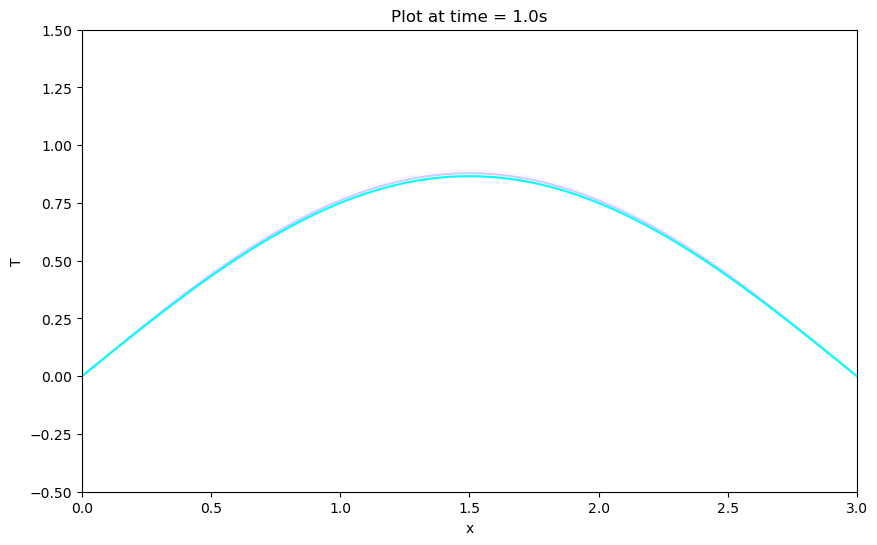

In [23]:
steps_6 = 20
t_min_plot_6 = 0             # default = 0
t_max_plot_6 = 1      # default = len(U_6)
x_min_plot_6 = 0             # default = 0
x_max_plot_6 = L_6           # default = L_6
PDE.PDE_plotter_1D(U_6, L_6, t_max_6, steps_6, t_min_plot_6, t_max_plot_6, x_min_plot_6, x_max_plot_6, alpha_decay=.2)

## 7a. Klein-Gordon (Nonlinear): $u_{tt} - u_{xx} + u + x^{-6}u^{7}$

In [11]:
# Initial Condition Functions
def f_u_0_x(x):
    '''
    Assigns the initial values (t=0) for u, inner nodes.
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return np.sin(np.pi*x)

def f_u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''    
    return 0

def f_u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

In [12]:
def test_1D_nonlinear_timestep(u_line,u_line_previous,m,dt,dx):
    '''
    Takes in
    u_line - an 1D array
    u_line_previous - an 1D array
    m - a space index 
    dt - time step
    dx - x step
    
    ***Add notes here about derivation from the centered difference from each side of the equation***
    '''
    x = m * dx
    return (dt**2/dx**2) * (u_line[m+1] + u_line[m-1] - 2*u_line[m]) - dt**2 * u_line[m] + 2 * u_line[m] - (dt**2/x**6) * u_line[m]**7 - u_line_previous[m]

In [13]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_7 = 1
t_max_7 = 1

dx_7 = .01
dt_7 = .0001

# -- Create a stability check
if dx_7/dt_7 < 1:
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.")

# -- Calculated
Nx_7 = int(L_7/dx_7) + 1
Nt_7 = int(t_max_7/dt_7) + 1

x_grid_7 = np.linspace(0,L_7,Nx_7)
t_grid_7 = np.linspace(0,t_max_7,Nt_7)

# -- Create solution data holder
U_7 = []

# -- Append initial conditions (t = 0) and boundary conditions (x = 0, x = L)
u_t_x_0 = [f_u_0_x(x) for x in x_grid_7]

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_7.append(u_t_x_0)

u_previous_2 = U_7[-1]

for j in range(len(t_grid_7)):
    u_t_x = []
    
    u_previous = U_7[-1]
    
    for m in range(1,len(x_grid_7)-1):
        u = test_1D_nonlinear_timestep(u_previous,u_previous_2,m,dt_7,dx_7)
        # Append this value to the time step line
        u_t_x.append(u)
        
    u_previous_2 = u_previous

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))

    # Now append the full solutions matrix
    U_7.append(u_t_x) 

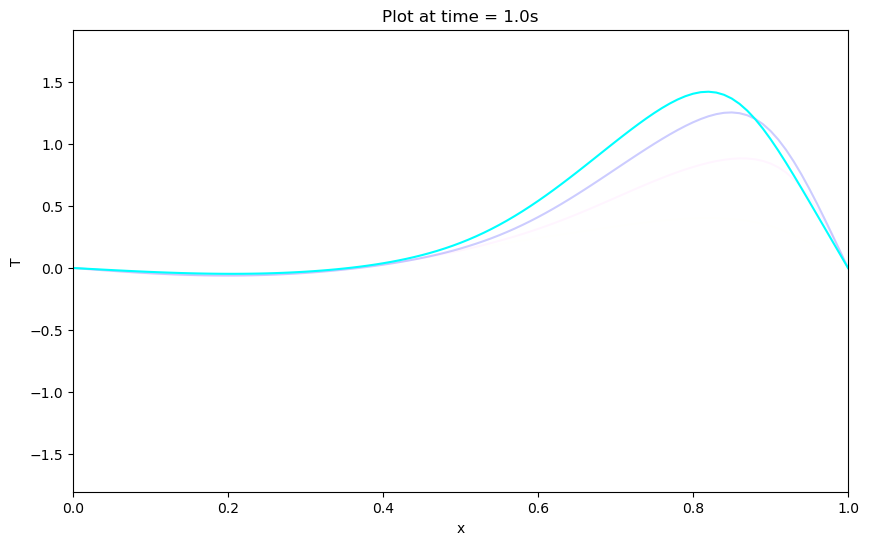

In [14]:
steps_7 = 20
t_min_plot_7 = 0             # default = 0
t_max_plot_7 = 1            # default = len(U_7)
x_min_plot_7 = 0            # default = 0
x_max_plot_7 = L_7            # default = t_max
PDE.PDE_plotter_1D(U_7, L_7, t_max_7, steps_7, t_min_plot_7, t_max_plot_7, x_min_plot_7, x_max_plot_7, alpha_decay = .2)

# ---Problems 7-9, Chapter 8---

##### Problem 7: Done by hand and then checked here.

In [28]:
def problem8_7(u_line,u_line_previous,c,m,dt,dx):
    '''
    Takes in
    u_line - an 1D array
    u_line_previous - an 1D array
    m - a space index
    dt - time step
    dx - x step
    
    ***Add notes here about derivation from the centered difference from each side of the equation***
    '''
    return ((dt**2/dx**2) * c**2 * (u_line[m+1] + u_line[m-1] - 2*u_line[m]) +
            2*u_line[m] - u_line_previous[m] + (dt * u_line[m]**3))

In [29]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_8 = 14
t_max_8 = 4

dx_8 = 1
dt_8 = 1

c = 1

# -- Create a stability check
if dx_8/dt_8 < 1:
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.")

# -- Calculated
Nx_8 = int(L_8/dx_8) + 1
Nt_8 = int(t_max_8/dt_8) + 1

x_grid_8 = np.linspace(0,L_8,Nx_8)
t_grid_8 = np.linspace(0,t_max_8,Nt_8)

# -- Create solution data holder
U_8 = []

# -- Append initial conditions (t = 0) and boundary conditions (x = 0, x = L)
u_t_x_0 = [0,0,0,0,0,0,1,2,1,0,0,0,0,0,0]

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_8.append(u_t_x_0)

# Create t = 1 step: = 1/2(u[-1])

u_t_x_1 = np.zeros(len(u_t_x_0))
for i in range(1,len(u_t_x_0)-1):
    u_t_x_1[i] = (u_t_x_0[i-1]+u_t_x_0[i+1])/2

u_t_x_1[0] = f_u_t_0(0)
u_t_x_1[-1] = f_u_t_L(0)

U_8.append(u_t_x_1)

for j in range(len(t_grid_8)-2):
    u_t_x = []
    
    u_previous = U_8[-1]
    u_previous_2 = U_8[-2]
    
    for m in range(1,len(x_grid_8)-1):
        u = problem8_7(u_previous,u_previous_2,c,m,dt_8,dx_8)
        # Append this value to the time step line
        u_t_x.append(u)
        
    u_previous_2 = u_previous

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))

    # Now append the full solutions matrix
    U_8.append(u_t_x) 

In [30]:
pd.DataFrame(U_8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.000,0.000000,0.000000,1.000000,2.0,1.000000,0.000000,0.000000,0.000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000,0.000000,0.500000,1.000000,1.0,1.000000,0.500000,0.000000,0.000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000,0.500000,1.125000,1.500000,1.0,1.500000,1.125000,0.500000,0.000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.500,1.250000,2.923828,4.500000,3.0,4.500000,2.923828,1.250000,0.500,0.0,0.0,0.0
4,0.0,0.0,0.5,1.375,4.876953,29.620137,95.548828,35.0,95.548828,29.620137,4.876953,1.375,0.5,0.0,0.0


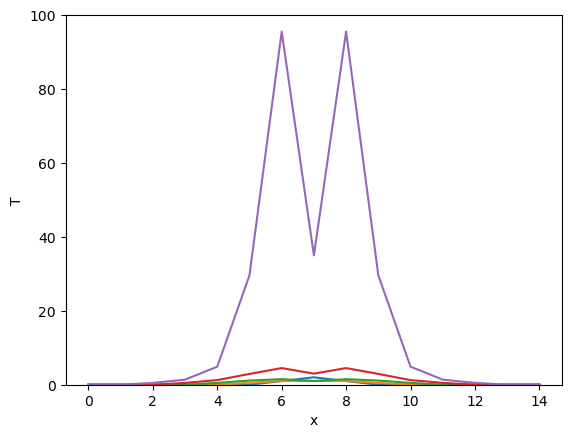

In [31]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in range(len(U_8)):
    plt.plot(U_8[i])
    plt.xlabel('x')
    plt.ylabel('T')
    plt.ylim(0,100)

plt.show()

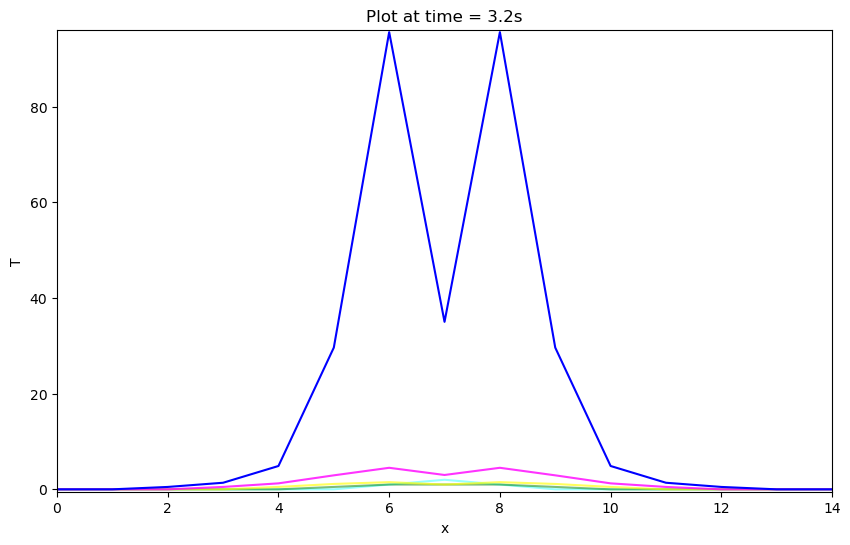

In [32]:
steps_8 = 5
t_min_plot_8 = 0             # default = 0
t_max_plot_8 = t_max_8           # default = len(U_7)
x_min_plot_8 = 0            # default = 0
x_max_plot_8 = L_8           # default = t_max
PDE.PDE_plotter_1D(U_8, L_8, t_max_8, steps_8, t_min_plot_8, t_max_plot_8, x_min_plot_8, x_max_plot_8, alpha_decay = .8)

##### Problem 8

Notice the change in the cubic term from plus to minus:

In [33]:
def problem8_8(u_line,u_line_previous,c,m,dt,dx):
    '''
    Takes in
    u_line - an 1D array
    u_line_previous - an 1D array
    m - a space index
    dt - time step
    dx - x step
    
    ***Add notes here about derivation from the centered difference from each side of the equation***
    '''
    return ((dt**2/dx**2) * c**2 * (u_line[m+1] + u_line[m-1] - 2*u_line[m]) +
            2*u_line[m] - u_line_previous[m] - (dt * u_line[m]**3))

In [34]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L_8 = 14
t_max_8 = 4

dx_8 = 1
dt_8 = 1

c = 1

# -- Create a stability check
if dx_8/dt_8 < 1:
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.")

# -- Calculated
Nx_8 = int(L_8/dx_8) + 1
Nt_8 = int(t_max_8/dt_8) + 1

x_grid_8 = np.linspace(0,L_8,Nx_8)
t_grid_8 = np.linspace(0,t_max_8,Nt_8)

# -- Create solution data holder
U_8 = []

# -- Append initial conditions (t = 0) and boundary conditions (x = 0, x = L)
u_t_x_0 = [0,0,0,0,0,0,1,2,1,0,0,0,0,0,0]

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U_8.append(u_t_x_0)

# Create t = 1 step: = 1/2(u[-1])

u_t_x_1 = np.zeros(len(u_t_x_0))
for i in range(1,len(u_t_x_0)-1):
    u_t_x_1[i] = (u_t_x_0[i-1]+u_t_x_0[i+1])/2

u_t_x_1[0] = f_u_t_0(0)
u_t_x_1[-1] = f_u_t_L(0)

U_8.append(u_t_x_1)

for j in range(len(t_grid_8)-2):
    u_t_x = []
    
    u_previous = U_8[-1]
    u_previous_2 = U_8[-2]
    
    for m in range(1,len(x_grid_8)-1):
        u = problem8_8(u_previous,u_previous_2,c,m,dt_8,dx_8)
        # Append this value to the time step line
        u_t_x.append(u)
        
    u_previous_2 = u_previous

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))

    # Now append the full solutions matrix
    U_8.append(u_t_x) 

In [35]:
pd.DataFrame(U_8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.000,0.000000,0.000000,1.000000,2.0,1.000000,0.000000,0.000000,0.000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000,0.000000,0.500000,1.000000,1.0,1.000000,0.500000,0.000000,0.000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000,0.500000,0.875000,-0.500000,-1.0,-0.500000,0.875000,0.500000,0.000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.500,0.750000,-1.169922,-1.000000,-1.0,-1.000000,-1.169922,0.750000,0.500,0.0,0.0,0.0
4,0.0,0.0,0.5,0.625,-1.591797,0.476292,-0.669922,0.0,-0.669922,0.476292,-1.591797,0.625,0.5,0.0,0.0


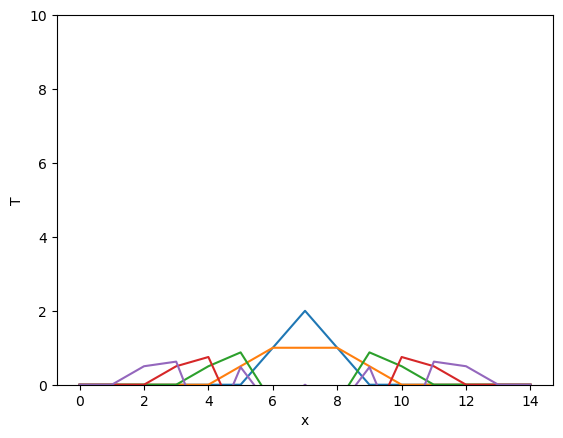

In [36]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in range(len(U_8)):
    plt.plot(U_8[i])
    plt.xlabel('x')
    plt.ylabel('T')
    plt.ylim(0,10)
plt.show()

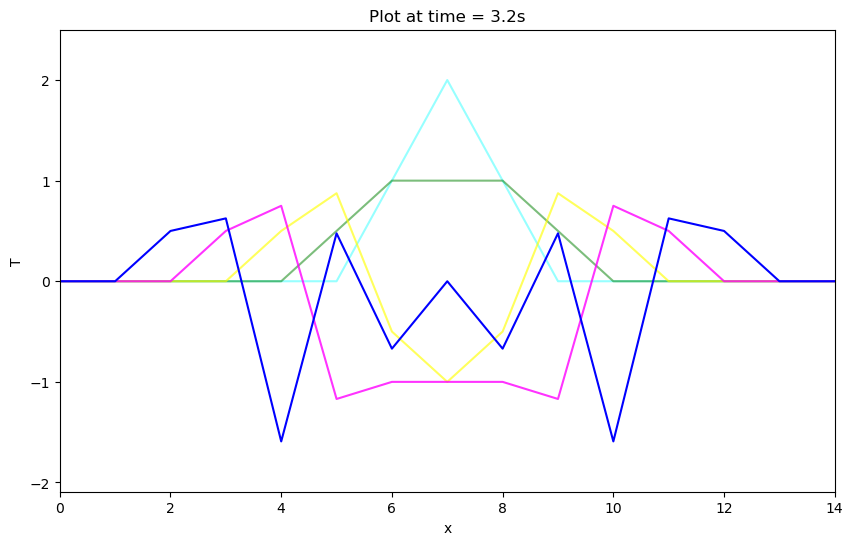

In [37]:
steps_8 = 5
t_min_plot_8 = 0             # default = 0
t_max_plot_8 = t_max_8           # default = len(U_7)
x_min_plot_8 = 0            # default = 0
x_max_plot_8 = L_8           # default = t_max
PDE.PDE_plotter_1D(U_8, L_8, t_max_8, steps_8, t_min_plot_8, t_max_plot_8, x_min_plot_8, x_max_plot_8, alpha_decay = .8)